# Predicting stroke

In [34]:
#Importing pandas:
import pandas as pd

#Importing matplotlib
import matplotlib.pyplot as plt

#Importing the df:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [36]:
#check unique values for each variables
for column in df:
    if len(df[column].unique()) < 10:
        print(df[column].unique())

['Male' 'Female' 'Other']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
[1 0]


## Issues with initial state of data
1. Most of the variables are strings (and categorical)
2. ever_married and Recidence_type can be made into binary
3. Uneven distributions of some of the variables - this is especially problematic for our target (stroke). 

 - The plot shows a really uneven distribution of the observations. This is something we have to fix.. (class_weight="balanced" in our random forrest https://datascience.stackexchange.com/questions/11404/python-handling-imbalance-classes-in-python-machine-learning).

<AxesSubplot:xlabel='stroke', ylabel='count'>

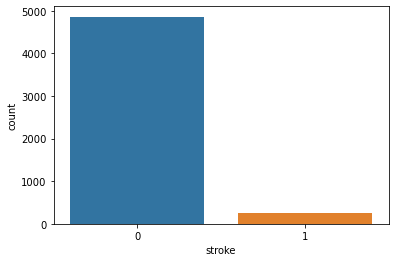

In [78]:
#relation - stroke and gender
sns.countplot(x='stroke', data=df)

## Cleaning the data

In [43]:
#Checking how often 'other' occurs in the gender variable:
df.groupby('gender').count() #The value is only occuring once - we are removing it in order to make it binary: 

,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,,
Female,2994,2994,2994,2994,2994,2994,2994,2994,2897,2994,2994
Male,2115,2115,2115,2115,2115,2115,2115,2115,2011,2115,2115
Other,1,1,1,1,1,1,1,1,1,1,1


In [44]:
#Remove 'other' entries in gender and binarize the rest
df = df.drop(index= df[df["gender"]=="Other"].index)
df['gender'] = (df['gender'] == 'Male').astype(int) #Male as 1, female as 0. 

In [45]:
#Binarize ever_married
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int) #Yes = 1

#Binarize Recidence_type
df['Residence_type'] = (df['Residence_type'] == 'Urban').astype(int) #Urban = 1
df = df.rename(columns={'Residence_type': 'Urban'}) #Renaming

df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Urban,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,0,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,0,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,0,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,1,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [46]:
#smoking is a string with four categories
df.groupby('smoking_status').count() 

#Recoding into numeric categories
def smoking_to_numeric(x):
        if x=='Unknown': return 0
        if x=='never smoked': return 1
        if x=='formerly smoked':return 2
        if x=='smokes':return 3

df['smoking_status_num'] = df['smoking_status'].apply(smoking_to_numeric)


In [47]:
#Smoking_status
print(df.work_type.unique())

['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']


In [48]:
#Repeating with work_type: 

def work_type_num(x):
        if x=='Never_worked': return 0
        if x=='children': return 1
        if x=='Govt_job':return 2
        if x=='Self-employed':return 3
        if x=='Private':return 4

df['work_type_num'] = df['work_type'].apply(work_type_num)

In [54]:
def stroke_format(x):
    if x == 1: return "Yes"
    if x == 0: return "No"

df['stroke_text'] = df['stroke'].apply(stroke_format)

### Dealing with nan values in the df: 

In [236]:
#Cheking for missing values: 
print(df.isnull().values.any())

True


In [237]:
#Seems like we have missing values in bmi:
nan_rows = df[df['bmi'].isnull()]
nan_rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Urban,avg_glucose_level,bmi,smoking_status,stroke,smoking_status_num,work_type_num
1,51676,0,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1,1,3
8,27419,0,59.0,0,0,1,Private,0,76.15,NaN,Unknown,1,0,4
13,8213,1,78.0,0,1,1,Private,1,219.84,NaN,Unknown,1,0,4
19,25226,1,57.0,0,1,0,Govt_job,1,217.08,NaN,Unknown,1,0,2
27,61843,1,58.0,0,0,1,Private,0,189.84,NaN,Unknown,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,1,41.0,0,0,0,Private,0,70.15,NaN,formerly smoked,0,2,4
5048,28788,1,40.0,0,0,1,Private,1,191.15,NaN,smokes,0,3,4
5093,32235,0,45.0,1,0,1,Govt_job,0,95.02,NaN,smokes,0,3,2
5099,7293,1,40.0,0,0,1,Private,0,83.94,NaN,smokes,0,3,4


- 201 missing BMI values 
- Recode the missing values to something specific (for example 0). At the same time, we should create a new dummy variable, indicating if the first variable (bmi), is missing or not. The point is, that we by doing so avoids missing values, but still allows the models to take them into account. 

In [238]:
import numpy as np
#Creating a new dummy variable - indicating wheter bmi is 0 or another value: 
df['bmi_dummy'] = np.where(df['bmi'].isna(),0,1)

#Cheking if it makes sense:
df.bmi_dummy.value_counts() #1 = real values, 0 =missing


1    4908
0     201
Name: bmi_dummy, dtype: int64

In [239]:
#Filling the missing values in bmi with 0 in the original column: 
df = df.fillna(0)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Urban,avg_glucose_level,bmi,smoking_status,stroke,smoking_status_num,work_type_num,bmi_dummy
0,9046,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1,2,4,1
1,51676,0,61.0,0,0,1,Self-employed,0,202.21,0.0,never smoked,1,1,3,0
2,31112,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1,1,4,1
3,60182,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1,3,4,1
4,1665,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,Private,1,83.75,0.0,never smoked,0,1,4,0
5106,44873,0,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0,1,3,1
5107,19723,0,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0,1,3,1
5108,37544,1,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0,2,4,1


## Descriptive statistics of the data

In [153]:
#function for percentage without hue consideration 
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

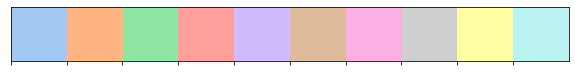

In [209]:
#setting colours
palette = sns.color_palette('pastel')
sns.palplot(palette)

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


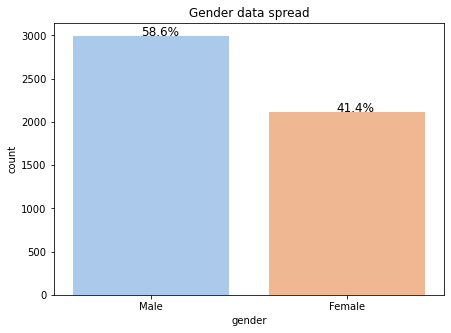

<Figure size 432x288 with 0 Axes>

In [214]:
#gender
plt.figure(figsize = (7,5))
ax = sns.countplot('gender', data =df)
sns.set_palette('pastel')
plt.xticks(size = 10)
plt.xlabel('gender')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Gender data spread')
positions = (0, 1)
labels = ("Male", "Female")
plt.xticks(positions, labels)
without_hue(ax, df.gender)
plt.savefig('gender graph')

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


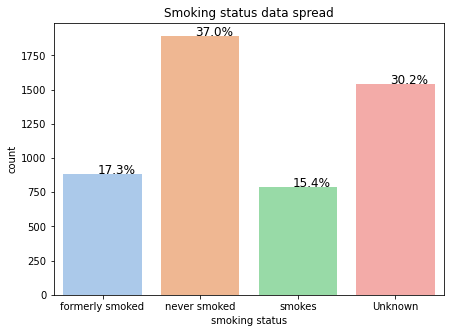

<Figure size 432x288 with 0 Axes>

In [213]:
#smoking status
plt.figure(figsize = (7,5))
ax = sns.countplot('smoking_status', data =df)
sns.set_palette('pastel')
plt.xticks(size = 10)
plt.xlabel('smoking status')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Smoking status data spread')
without_hue(ax, df.smoking_status)
plt.savefig('smoking status graph')

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


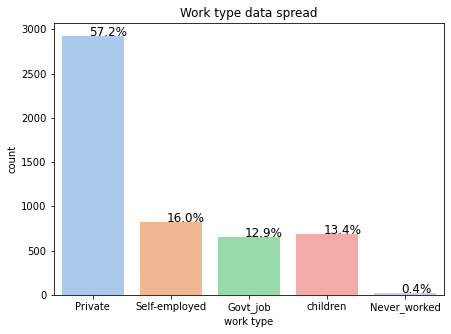

<Figure size 432x288 with 0 Axes>

In [215]:
#work type
plt.figure(figsize = (7,5))
ax = sns.countplot('work_type', data =df)
sns.set_palette('pastel')
plt.xticks(size = 10)
plt.xlabel('work type')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Work type data spread')
without_hue(ax, df.smoking_status)
plt.savefig('work type graph')

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


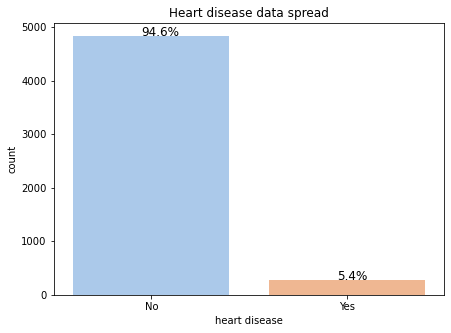

<Figure size 432x288 with 0 Axes>

In [243]:
#heart disease
plt.figure(figsize = (7,5))
ax = sns.countplot('heart_disease', data =df)
sns.set_palette('pastel')
positions = (0, 1)
labels = ("No", "Yes")
plt.xticks(positions, labels)
plt.xticks(size = 10)
plt.xlabel('heart disease')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Heart disease data spread')
without_hue(ax, df.smoking_status)
plt.savefig('heart disease graph')

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


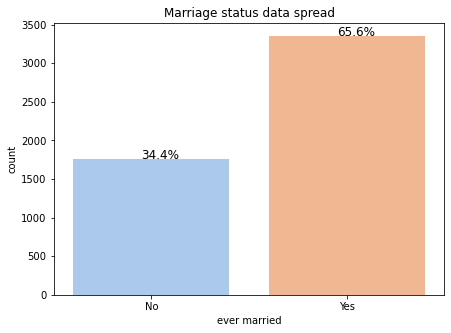

<Figure size 432x288 with 0 Axes>

In [245]:
#marriage status
plt.figure(figsize = (7,5))
ax = sns.countplot('ever_married', data =df)
sns.set_palette('pastel')
positions = (0, 1)
labels = ("No", "Yes")
plt.xticks(positions, labels)
plt.xticks(size = 10)
plt.xlabel('ever married')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Marriage status data spread')
without_hue(ax, df.ever_married)
plt.savefig('marriage graph')

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


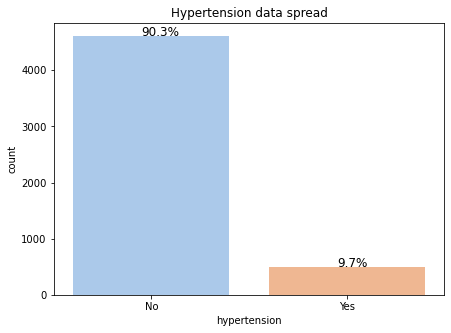

<Figure size 432x288 with 0 Axes>

In [246]:
#bmi
plt.figure(figsize = (7,5))
ax = sns.countplot('hypertension', data =df)
sns.set_palette('pastel')
positions = (0, 1)
labels = ("No", "Yes")
plt.xticks(positions, labels)
plt.xticks(size = 10)
plt.xlabel('hypertension')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Hypertension data spread')
without_hue(ax, df.ever_married)
plt.savefig('hypertension graph')

/Users/natalijaglisovic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


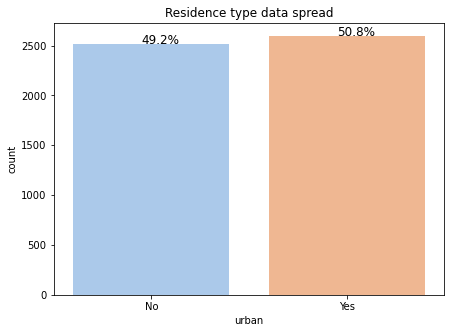

<Figure size 432x288 with 0 Axes>

In [265]:
#residence type 
plt.figure(figsize = (7,5))
ax = sns.countplot('Urban', data =df)
sns.set_palette('pastel')
positions = (0, 1)
labels = ("No", "Yes")
plt.xticks(positions, labels)
plt.xticks(size = 10)
plt.xlabel('urban')
plt.yticks(size = 10)
plt.ylabel('count')
plt.title('Residence type data spread')
without_hue(ax, df.Urban)
plt.savefig('residence graph.png', dpi = 100)
plt.show()

<Figure size 864x576 with 0 Axes>

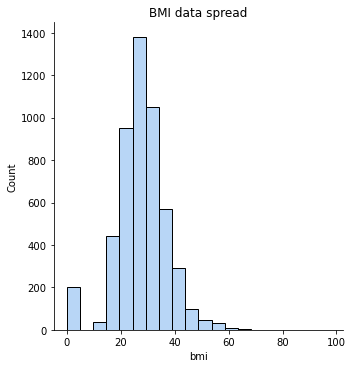

In [277]:
#bmi spread - a lot close to average
plt.figure(figsize = (12,8))
sns.displot(df, x="bmi", bins = 20)
plt.title('BMI data spread')
plt.savefig('bmi.png', dpi = 100)

Text(0.5, 1.0, 'Age data spread')

<Figure size 864x576 with 0 Axes>

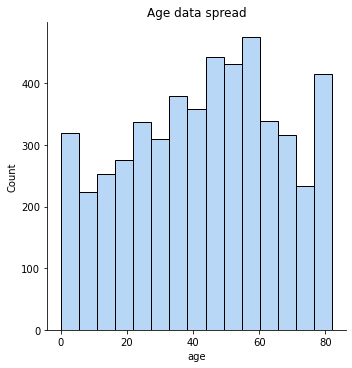

In [281]:
#age spread - very dispersed
plt.figure(figsize = (12,8))
sns.displot(df, x="age", bins = 15)
plt.title('Age data spread')
#plt.savefig('bmi.png', dpi = 100)

Text(0.5, 1.0, 'Average blood glucose level data spread')

<Figure size 864x576 with 0 Axes>

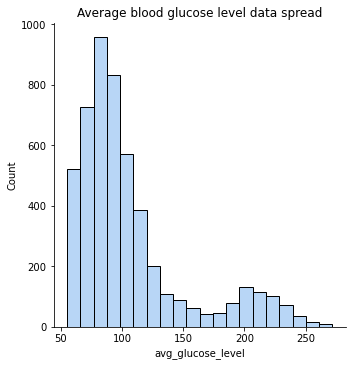

In [285]:
#blood glucose spread - clustered around average values
plt.figure(figsize = (12,8))
sns.displot(df, x="avg_glucose_level", bins = 20)
plt.title('Average blood glucose level data spread')
#plt.savefig('bmi.png', dpi = 100)

In [4]:
df_non_stroke = df[df['stroke'] == 0]
df_stroke = df[df['stroke'] == 1]

In [56]:
df_stroke_ordered = df.sort_values(by=['stroke'], ascending=True)

In [57]:
df_stroke_ordered

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Urban,avg_glucose_level,bmi,smoking_status,stroke,smoking_status_num,work_type_num,stroke_text
2554,72369,0,14.0,0,0,0,children,0,65.41,19.5,Unknown,0,0,1,No
3410,28315,1,38.0,0,0,1,Private,0,108.68,32.7,never smoked,0,1,4,No
3409,56996,1,44.0,0,0,1,Private,1,65.41,24.8,smokes,0,3,4,No
3408,52588,0,63.0,0,0,1,Private,0,85.81,35.6,never smoked,0,1,4,No
3407,10243,0,60.0,0,0,1,Govt_job,1,73.04,25.3,never smoked,0,1,2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,34567,0,81.0,1,0,1,Self-employed,0,74.02,25.0,never smoked,1,1,3,Yes
158,66258,0,71.0,0,0,1,Self-employed,1,195.71,34.1,formerly smoked,1,2,3,Yes
157,59437,0,57.0,0,0,1,Private,1,221.89,37.3,smokes,1,3,4,Yes
170,28939,1,64.0,0,0,1,Self-employed,0,111.98,NaN,formerly smoked,1,2,3,Yes


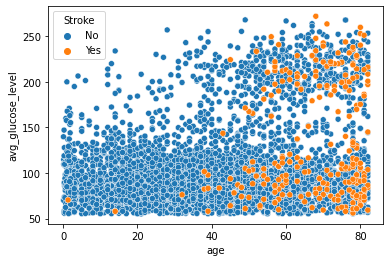

In [63]:
#scatter to illustrate relationship between age, stroke and blood glucose level
ax = sns.scatterplot(data=df_stroke_ordered, x="age", y="avg_glucose_level", hue="stroke_text")
ax.legend(title="Stroke")
ax.get_figure().savefig('stroke_age_gluc')

## Splitting the data for machine learning

In [19]:
print(df.keys())

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Urban', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'smoking_status_num', 'work_type_num', 'bmi_dummy'],
      dtype='object')


In [20]:
#Got an error when creating x and y - this helps. 
df.columns = df.columns.to_series().apply(lambda x: x.strip())

#Creating X and Y: 

X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Urban', 'avg_glucose_level', 'bmi', 'bmi_dummy','smoking_status_num','work_type_num']] #adding all x's

Y = df[['stroke']] #defining the target we want to predict

In [21]:
#Importing modules:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#Randomly splitting the dataset into training and testing sets:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #Setting seed to 42

## Choosing the right model

- The nature of the dependent variable differentiates regression and classification problems. Regression problems have continuois and unbound outputs (https://realpython.com/logistic-regression-python/). Classification problems have discrete outputs called categories. 
- Our target is a binary variable with two possible outcomes (1 or 0 indicating wheter stroke or no stroke). We are therefore dealing with a classification problem, meaning that a linear model is unsuitable 

## Supervised learning using logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1000, random_state=42, class_weight= 'balanced') #BALANCED
logistic.fit(x_train, np.ravel(y_train))
yhat_test = logistic.predict(x_test)

#Cheking shape before reshaping (here we see that they have different shapes)
print("Before reshape")
print("yhat_test: ", yhat_test.shape) 
print("y_test: ", y_test.shape) 

#reshaping to make sure that yhat_tast and y_test have the same shape.
yhat_test = yhat_test.reshape(-1,1) 

#Checking shape after reshaping
print("After reshape")
print("yhat_test: ", yhat_test.shape) 
print("y_test: ", y_test.shape)

acc = (yhat_test==y_test).sum()/len(y_test)*100
print(f"Kmeans accuracy:", float(acc),"%")

Before reshape
yhat_test:  (1022,)
y_test:  (1022, 1)
After reshape
yhat_test:  (1022, 1)
y_test:  (1022, 1)
Kmeans accuracy: 74.95107632093934 %


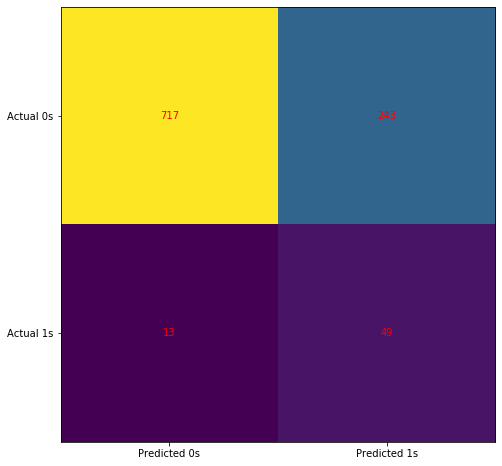

In [27]:
#Confusion matrix: (To get more information on the accuracy of the model)
cm = confusion_matrix(y_test, yhat_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Supervised learning using Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=42, class_weight= 'balanced') #BALANCED
rf.fit(x_train, np.ravel(y_train))
yhat_test = rf.predict(x_test)

#Cheking shape before reshaping (here we see that they have different shapes)
print("Before reshape")
print("yhat_test: ", yhat_test.shape) 
print("y_test: ", y_test.shape) 

#reshaping to make sure that yhat_tast and y_test have the same shape.
yhat_test = yhat_test.reshape(-1,1) 

#Checking shape after reshaping
print("After reshape")
print("yhat_test: ", yhat_test.shape) 
print("y_test: ", y_test.shape)

acc = (yhat_test==y_test).sum()/len(y_test)*100
print(f"Kmeans accuracy:", float(acc),"%")

Before reshape
yhat_test:  (1022,)
y_test:  (1022, 1)
After reshape
yhat_test:  (1022, 1)
y_test:  (1022, 1)
Kmeans accuracy: 65.36203522504891 %


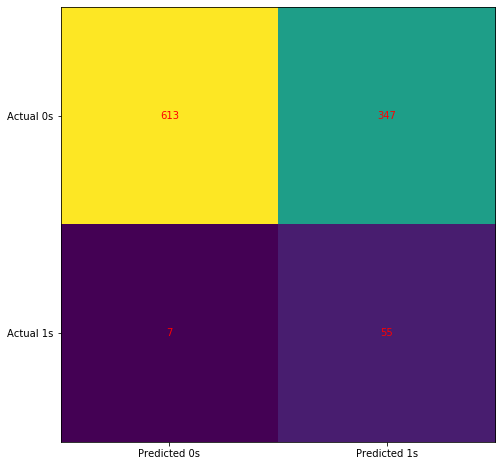

In [29]:
#Confusion matrix: (To get more information on the accuracy of the model)

cm = confusion_matrix(y_test, yhat_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

# K-Fold cross-validation

- In this section we will perform k-fold cross-validation - this is often a prefered method as this allows us to train our data on several splits of the training data, which in turn gives us a better indication of how well the model will perform out-of-sample.
- Evaluating the performance of logistic regression and random forrest (the models that performed best above). 
- We already splitted the dataset into test and train. We can use these sets again

## Logistic regression

In [30]:
#Cross-validation
from sklearn.model_selection import cross_val_score

#Defining our model (the same as above)
logistic_ = LogisticRegression(max_iter=1000, random_state=42, class_weight= 'balanced') #BALANCED

#lets do 5-fold cross validation
cv_scores = cross_val_score(logistic_, x_train, y_train.values.ravel(), cv=5) #5 folds

#print each cv score (accuracy) and average them
print("all acc cv scores:", cv_scores)
print('cv_scores mean (acc):{}'.format(np.mean(cv_scores)))

all acc cv scores: [0.74205379 0.74694377 0.73439412 0.75887393 0.77233782]
cv_scores mean (acc):0.7509206860330447


#### Gridsearch
- In the model above we worked with default parameters determined by the LogisticRegression module. It is therefor possible that the model can be improved by tuning the hyperparameters of the model. 

- To do so we define a grid of parameters, and efterwards test them and select the best one for our model. This can be done using Gridsearch. 

In [31]:
#importing the module
from sklearn.model_selection import GridSearchCV

- Logistic regression does not really have any critical hyperparameters to tune.

In [32]:
# initiate the Logistic regression 
logistic_ = LogisticRegression(max_iter=1000, random_state=42, class_weight= 'balanced')

#Sometimes, you can see useful differences in performance or convergence with different solvers (solver).
solvers = ['newton-cg', 'lbfgs', 'liblinear']
#Regularization (penalty) can sometimes be helpful.
penalty = ['l2']
#The C parameter controls the penality strength, which can also be effective.
c_values = [100, 10, 1.0, 0.1, 0.01]

#Defining the grid search_ 
grid = dict(solver=solvers,penalty=penalty,C=c_values)

grid_search = GridSearchCV(logistic_, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)

In [33]:
grid_result = grid_search.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.751165 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750676 (0.013843) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.750676 (0.013843) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750676 (0.013843) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.750676 (0.013843) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.750431 (0.013939) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750431 (0.013939) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.751165 (0.013892) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751165 (0.013849) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750431 (0.013939) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.749208 (0.013749) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.749207 (0.013535) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.747738 (0.010948) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.744067 (0.012644) with: {

Best result: 
- Best: 0.751165 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

- Now we want to evaluate how our final logistic regression model performs on the validationset and the trainingset. 

In [35]:
#Defining our final model: 
final_logistic = grid_search.best_estimator_ 

#Predicting the final logistic regression model from our best perfoming model: 

y_pred_best_log = final_logistic.predict(x_train)
y_pred_best_log_test = final_logistic.predict(x_test)

from sklearn import metrics

#Compute the accuracy, precision, recall and f score for both sets
#using metrics

acc_log = final_logistic.score(x_train, y_train)
precision_log = metrics.precision_score(y_train, y_pred_best_log)
recall_log = metrics.recall_score(y_train, y_pred_best_log)
fscore_log = metrics.f1_score(y_train, y_pred_best_log)

acc_log_test = final_logistic.score(x_test, y_test)
precision_log_test = metrics.precision_score(y_test, y_pred_best_log_test)
recall_log_test = metrics.recall_score(y_test, y_pred_best_log_test)
fscore_log_test = metrics.f1_score(y_test, y_pred_best_log_test)

In [36]:
#Compare the results
print("Within-sample acc:", acc_log)
print("Within-sample precision:", precision_log)
print("Within-sample recall:", recall_log)
print("Within-sample F score:", fscore_log)

print("Out-of-sample acc:", acc_log_test)
print("Out-of-sample precision:", precision_log_test)
print("Out-of-sample recall:", recall_log_test)
print("Out-of-sample F score:", fscore_log_test)

Within-sample acc: 0.7523856129190115
Within-sample precision: 0.13527851458885942
Within-sample recall: 0.8181818181818182
Within-sample F score: 0.23216995447647953
Out-of-sample acc: 0.7495107632093934
Out-of-sample precision: 0.1678082191780822
Out-of-sample recall: 0.7903225806451613
Out-of-sample F score: 0.2768361581920904


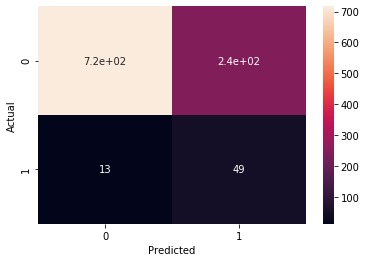

In [62]:
import seaborn as sn
data = {'y_Actual':    np.ravel(y_test), 'y_Predicted': y_pred_best_log_test}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

- When tuning the model we get a better accuracy - not much better, but a bit!
- We are especially interested in actual strokes - important to cath possible strokes which means that false negatives are the worst senario in this case (13). False-positive cases are likewise a problem (240), but not to the same degree. It is better to get false positives leading to an extra check up, than false-negatives where the patient is in a big risk, but the classifier says otherwise. 

## Random forest

In [37]:
#Defining our model (the same as above)
rf_ = RandomForestClassifier(max_depth=2, random_state=42, class_weight= 'balanced') #BALANCED

cv_scores1 = cross_val_score(rf_, x_train, y_train.values.ravel(), cv=5) #5 folds

#print each cv score (accuracy) and average them
print("all acc cv scores:", cv_scores1)
print('cv_scores mean (acc):{}'.format(np.mean(cv_scores1)))

all acc cv scores: [0.67603912 0.67848411 0.67564259 0.69522644 0.66707466]
cv_scores mean (acc):0.6784933847668584


#### Gridsearch



In [38]:
#initiate the models and parameters
rf_ = RandomForestClassifier(max_depth=2, random_state=42, class_weight= 'balanced') 
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

#Defining the grid search_ 
grid1 = dict(n_estimators=n_estimators,max_features=max_features)

grid_search1 = GridSearchCV(rf_, param_grid=grid1, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)

In [39]:
grid_result1 = grid_search1.fit(x_train, y_train.values.ravel())

In [40]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means1 = grid_result1.cv_results_['mean_test_score']
stds1 = grid_result1.cv_results_['std_test_score']
params1 = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.831166 using {'max_features': 'sqrt', 'n_estimators': 10}
0.750676 (0.013843) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.750676 (0.013843) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750676 (0.013843) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.750676 (0.013843) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.750431 (0.013939) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750431 (0.013939) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.751165 (0.013892) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751165 (0.013849) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750431 (0.013939) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.749208 (0.013749) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.749207 (0.013535) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.747738 (0.010948) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.744067 (0.012644) with: {'C

In [41]:
#Defining our final model: 
final_rf = grid_search1.best_estimator_ 

#Predicting the final rf regression model from our best perfoming model: 

y_pred_best_rf = final_rf.predict(x_train)
y_pred_best_rf_test = final_rf.predict(x_test)

#Compute the accuracy, precision, recall and f score for both sets
#using metrics

acc_rf = final_rf.score(x_train, y_train)
precision_rf = metrics.precision_score(y_train, y_pred_best_rf)
recall_rf = metrics.recall_score(y_train, y_pred_best_rf)
fscore_rf = metrics.f1_score(y_train, y_pred_best_rf)

acc_rf_test = final_rf.score(x_test, y_test)
precision_rf_test = metrics.precision_score(y_test, y_pred_best_rf_test)
recall_rf_test = metrics.recall_score(y_test, y_pred_best_rf_test)
fscore_rf_test = metrics.f1_score(y_test, y_pred_best_rf_test)

In [42]:
#Compare the results
print("Within-sample acc:", acc_rf)
print("Within-sample precision:", precision_rf)
print("Within-sample recall:", recall_rf)
print("Within-sample F score:", fscore_rf)

print("Out-of-sample acc:", acc_rf_test)
print("Out-of-sample precision:", precision_rf_test)
print("Out-of-sample recall:", recall_rf_test)
print("Out-of-sample F score:", fscore_rf_test)

Within-sample acc: 0.8204061658918522
Within-sample precision: 0.1461836998706339
Within-sample recall: 0.6042780748663101
Within-sample F score: 0.2354166666666667
Out-of-sample acc: 0.7984344422700587
Out-of-sample precision: 0.16037735849056603
Out-of-sample recall: 0.5483870967741935
Out-of-sample F score: 0.2481751824817518


- Much better accuracy when tuning the model! (65% vs 80%). 


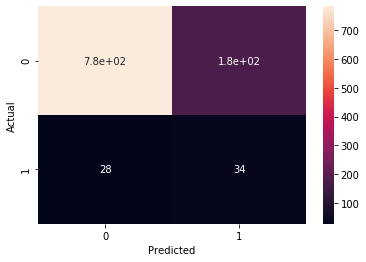

In [61]:
data = {'y_Actual':    np.ravel(y_test), 'y_Predicted': y_pred_best_rf_test}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

- Not perfect, but better than earlier. 
- We are especially interested in actual strokes - important to pick-up possible strokes which means that false negatives are the worst senarios in this case (28). False-positive cases are likewise a problem (180), but not to the same degree. It is better to get false positives leading to an extra check up, than false-negatives where the patient is in a big risk, but the classifier says otherwise.  

## Overall conclusion

- The tuned models are performing best (compared to test-split prediction and basic cross-validation). 
- Random forrest has the best accuracy, but the model using logistic regression is having less false negatives. In this case (when we are dealing with life and dead), it is probably most important to take the frequency of false-negatives into account. 
